In [105]:
from mads_datasets.base import BaseDatastreamer
from mltrainer.preprocessors import BasePreprocessor
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch import nn
import torch
from mltrainer import Trainer, TrainerSettings, ReportTypes
import tomllib
import seaborn as sns
import numpy as np
from torch import Tensor
import math
from typing import List, Tuple, Dict, Any, Union
from src import datasets, metrics
import mltrainer
import mlflow


mltrainer.__version__

'0.1.129'

In [106]:

def test_model(model, teststreamer):
    y_true = []
    y_pred = []
    #model = model.to("cpu")

    #testdata = [(x.to(device), y.to(device)) for x, y in teststreamer.stream()]
    testdata = teststreamer.stream()
    for _ in range(len(teststreamer)):
        X, y = next(testdata)

        yhat = model(X)
        yhat = yhat.argmax(dim=1) # we get the one with the highest probability
        y_pred.append(yhat.cpu().tolist())
        y_true.append(y.cpu().tolist())

    yhat = [x for y in y_pred for x in y]
    y = [x for y in y_true for x in y]
    return y, yhat

def plot_confusion_matrix(cfm):
    plot = sns.heatmap(cfm, annot=cfm, fmt=".3f")
    plot.set(xlabel="Predicted", ylabel="Target")
    plt.show()

# difference between test and train
def calculate_difference(train_scores_str, test_scores_str):
    # Remove the brackets and split the string by spaces
    str_list = test_scores_str.strip('[]').split()

    # Convert each element to a float
    test_scores_str = [float(num) for num in str_list]

    test_scores = [float(x) for x in test_scores_str]
    train_scores = [float(x) for x in train_scores_str]
    difference = [str(np.round(test - train, 3)) for test, train in zip(test_scores, train_scores)]
    print(f'train loss average:{np.round(np.mean(test_scores), 3)}')
    print(f'test loss average:{np.round(np.mean(test_scores), 3)}')

    return difference



In [107]:
def train_model(trainstreamer, teststreamer, config, settings=None):

        loss_fn = torch.nn.CrossEntropyLoss()

        with mlflow.start_run():
            optimizer = torch.optim.Adam

            if settings==None:
                # default settings
                settings = TrainerSettings(
                    epochs=15,
                    metrics=[accuracy, f1micro, f1macro, precision, recall],
                    logdir="logs/heart2D",
                    train_steps=len(trainstreamer) // 5,
                    valid_steps=len(teststreamer) // 5,
                    reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
                    scheduler_kwargs={"factor": 0.5, "patience": 2},
                    earlystop_kwargs={"patience": 8},
                )



            trainer = Trainer(
                model=model,
                settings=settings,
                loss_fn=loss_fn,
                optimizer=optimizer,
                traindataloader=trainstreamer.stream(),
                validdataloader=teststreamer.stream(),
                scheduler= config["scheduler"],
            )

            mlflow.set_tag("model", config["model"])
            mlflow.set_tag("dataset", "heart_big_SMOTE")
            mlflow.log_param("scheduler", str(trainer.scheduler).split(".")[-1])
            mlflow.log_param("earlystop", str(settings.earlystop_kwargs))

            base_config = {
                "hidden": config["hidden"],
                "dropout": config["dropout"],
                "num_classes": config["num_classes"],
                "num_heads": config["num_heads"],
                "num_blocks": config["num_blocks"],
                "shape": config["shape"]
            }
            mlflow.log_params(base_config)
            mlflow.log_param("epochs", settings.epochs)
            mlflow.log_param("shape0", config["shape"])
            mlflow.log_param("optimizer", str(optimizer))
            mlflow.log_params(settings.optimizer_kwargs)
            trainer.loop()



In [67]:
datadir = Path('../data')
configfile = Path("config.toml")

with configfile.open('rb') as f:
    config = tomllib.load(f)
print(config)

{'ptb': 'heart', 'arrhythmia': 'heart_big'}


In [3]:
trainfile = datadir / (config['arrhythmia'] + '_oversampled_full_train.parq')
testfile = datadir / (config['arrhythmia'] + '_test.parq')
trainfile, testfile

(PosixPath('../data/heart_big_oversampled_full_train.parq'),
 PosixPath('../data/heart_big_test.parq'))

In [68]:
trainfile = datadir / (config['arrhythmia'] + '_SMOTE_train.parq')
testfile = datadir / (config['arrhythmia'] + '_test.parq')
trainfile, testfile

(PosixPath('../data/heart_big_SMOTE_train.parq'),
 PosixPath('../data/heart_big_test.parq'))

In [4]:
train_df = pd.read_parquet(trainfile)
test_df = pd.read_parquet(testfile)

Load the data

In [5]:
# load data in dataframes
train_df = pd.read_parquet(trainfile)
test_df = pd.read_parquet(testfile)

Positional encoding to use with the transformer.

In [7]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_seq_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_seq_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(1, max_seq_len, d_model)
        # batch, seq_len, d_model
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[batch_size, seq_len, embedding_dim]``
        """
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

In [8]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
    def forward(self, x):
        
        return self.conv(x)

In [9]:
import torch
class CNN(nn.Module):
    def __init__(self, config: dict) -> None:
        super().__init__()
        hidden = config['hidden']
        self.convolutions = nn.ModuleList([
            ConvBlock(1, hidden),
        ])

        for i in range(config['num_blocks']):
            self.convolutions.extend([ConvBlock(hidden, hidden), nn.ReLU()])
        self.convolutions.append(nn.MaxPool2d(2, 2))

        self.dense = nn.Sequential(
            nn.Flatten(),
            nn.Linear((8*6) * hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, config['num_classes']),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for conv in self.convolutions:
            x = conv(x)
        x = self.dense(x)
        return x

In [10]:
class TransformerBlock(nn.Module):
    def __init__(self, hidden_size, num_heads, dropout):
        # feel free to change the input parameters of the constructor
        super(TransformerBlock, self).__init__()
        self.attention = nn.MultiheadAttention(
            embed_dim=hidden_size,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True,
        )
        self.ff = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
        )
        self.layer_norm1 = nn.LayerNorm(hidden_size)
        self.layer_norm2 = nn.LayerNorm(hidden_size)

    def forward(self, x):
        identity = x.clone() # skip connection
        x, _ = self.attention(x, x, x)
        x = self.layer_norm1(x + identity) # Add & Norm skip
        identity = x.clone() # second skip connection
        x = self.ff(x)
        x = self.layer_norm2(x + identity) # Add & Norm skip
        return x

In [11]:
shape = (16, 12)
traindataset = datasets.HeartDataset2D(trainfile, target="target", shape=shape)
testdataset = datasets.HeartDataset2D(testfile, target="target", shape=shape)
traindataset, testdataset

(Heartdataset2D (#275000), Heartdataset2D (#21892))

In [12]:
trainstreamer = BaseDatastreamer(traindataset, preprocessor = BasePreprocessor(), batchsize=32)
teststreamer = BaseDatastreamer(testdataset, preprocessor = BasePreprocessor(), batchsize=32)
len(trainstreamer), len(teststreamer)

(8593, 684)

In [29]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mads_exam.db")
mlflow.set_experiment("Transformer2DResNetSE")

<Experiment: artifact_location='/Users/francesca/code_repo/MADS-exam-25/notebooks/mlruns/11', creation_time=1737887993995, experiment_id='11', last_update_time=1737887993995, lifecycle_stage='active', name='Transformer2DResNetSE', tags={}>

## Adding RESNET BLOCK TO TRANSFORMER + 2D CNN + SE BLOCK

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the 2D ResNet Block
class ResNetBlock2D(nn.Module):
    def __init__(self, in_channels: int, out_channels: int) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # If input and output sizes do not match, apply a projection (1x1 conv)
        self.projection = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x  # Store the input for the skip connection

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)

        # Add the input to the output (skip connection)
        x += self.projection(identity)
        x = self.relu(x)

        return x


class Transformer2DResNet(nn.Module):
    def __init__(self, config: dict) -> None:
        super().__init__()

        # Modify the initial Conv2D to accept 1 input channels 
        self.conv2d = nn.Conv2d(
            in_channels=1,  # Adjusted input channels if needed
            out_channels=config["hidden"],
            kernel_size=3,
            stride=2,
            padding=1,
        )
        #print('2d conv')

        # Add ResNet Block (2D)
        self.resnet_block = ResNetBlock2D(config["hidden"], config["hidden"])
        print('resnet block')

        # Positional Encoding for Transformer input
        self.pos_encoder = PositionalEncoding(config["hidden"], config["dropout"])
        #print('positional encoding')

        # Create multiple transformer blocks
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(config["hidden"], config["num_heads"], config["dropout"])
            for _ in range(config["num_blocks"])
        ])

        # Final output layers
        self.out = nn.Sequential(
            nn.Linear(config["hidden"], config["hidden"] // 2),
            nn.ReLU(),
            nn.Dropout(config["dropout"]),
            nn.Linear(config["hidden"] // 2, config["num_classes"]),
        )

# - streamer:         (batch, seq_len, channels)
# - conv1d:           (batch, channels, seq_len)
# - pos_encoding:     (batch, seq_len, channels)
# - gru (batchfirst): (batch, seq_len, channels)
# - attention:        (batch, seq_len, channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
       # print("input", x.shape)
        x = x.view(32, 1, 16, 12) # reshape to 2D
       # print("input", x.shape)
        # Apply Conv2D to the input (convert from (batch, channels, height, width) to (batch, hidden, height, width))
        x = self.conv2d(x)  # (batch, hidden, height//2, width//2)
       # print("input afte cov2", x.shape)
        # Apply ResNet Block (2D)
        x = self.resnet_block(x)  # (batch, hidden, height//2, width//2)

        # Apply positional encoding (convert back to (batch, seq_len, channels))
        x = self.pos_encoder(x.flatten(2).transpose(1, 2))  # Flatten and transpose to (batch, seq_len, channels)

        # Apply multiple transformer blocks
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x)

        # Global Average Pooling
        x = x.mean(dim=1)  # (batch, hidden)

        # Final classification layers
        x = self.out(x)  # (batch, num_classes)
        return x



In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Linear(channel, channel // reduction)
        self.fc2 = nn.Linear(channel // reduction, channel)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Squeeze: Global Average Pooling
        b, c, _, _ = x.size()  # batch_size, channels, height, width
        squeeze = F.adaptive_avg_pool2d(x, (1, 1))  # (b, c, 1, 1)
        squeeze = squeeze.view(b, c)  # Flatten to (b, c)

        # Excitation: Fully connected layers + sigmoid activation
        excitation = F.relu(self.fc1(squeeze))
        excitation = self.sigmoid(self.fc2(excitation)).view(b, c, 1, 1)  # (b, c, 1, 1)

        # Recalibration: Re-weight the original feature maps
        return x * excitation.expand_as(x)


class Transformer2DResNetSE(nn.Module):
    def __init__(self, config: dict) -> None:
        super().__init__()

        # Initial Conv2D Layer
        self.conv2d = nn.Conv2d(
            in_channels=1,  # Adjusted input channels if needed
            out_channels=config["hidden"],
            kernel_size=3,
            stride=2,
            padding=1,
        )

        # ResNet Block (2D)
        self.resnet_block = ResNetBlock2D(config["hidden"], config["hidden"])

        # Squeeze-and-Excitation (SE) block after ResNet block
        self.se_block = SEBlock(config["hidden"])

        # Positional Encoding for Transformer input
        self.pos_encoder = PositionalEncoding(config["hidden"], config["dropout"])

        # Create multiple transformer blocks
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(config["hidden"], config["num_heads"], config["dropout"])
            for _ in range(config["num_blocks"])
        ])

        # Final output layers
        self.out = nn.Sequential(
            nn.Linear(config["hidden"], config["hidden"] // 2),
            nn.ReLU(),
            nn.Dropout(config["dropout"]),
            nn.Linear(config["hidden"] // 2, config["num_classes"]),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Reshape input to 2D (batch, channels, height, width)
        x = x.view(x.size(0), 1, 16, 12)

        # Apply Conv2D to the input
        x = self.conv2d(x)  # (batch, hidden, height, width)

        # Apply ResNet Block (2D)
        x = self.resnet_block(x)  # (batch, hidden, height//2, width//2)

        # Apply SE Block to recalibrate features
        x = self.se_block(x)

        # Apply positional encoding (convert back to (batch, seq_len, channels))
        x = self.pos_encoder(x.flatten(2).transpose(1, 2))  # Flatten and transpose to (batch, seq_len, channels)

        # Apply multiple transformer blocks
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x)

        # Global Average Pooling
        x = x.mean(dim=1)  # (batch, hidden)

        # Final classification layers
        x = self.out(x)  # (batch, num_classes)
        return x


In [32]:
shape = (16, 12)
traindataset = datasets.HeartDataset2D(trainfile, target="target", shape=shape)
testdataset = datasets.HeartDataset2D(testfile, target="target", shape=shape)
x, y = traindataset[20]
x.shape, y

(torch.Size([1, 16, 12]), tensor(0))

In [33]:
#Load the datastreamers
trainstreamer = BaseDatastreamer(traindataset, preprocessor = BasePreprocessor(), batchsize=32)
teststreamer = BaseDatastreamer(testdataset, preprocessor = BasePreprocessor(), batchsize=32)
print(len(trainstreamer), len(teststreamer))
x, y = next(trainstreamer.stream())
x.shape, y.shape

8593 684


(torch.Size([32, 1, 16, 12]), torch.Size([32]))

In [48]:
from src import models
config = {
    "hidden": 128,
    "dropout": 0.2,
    "num_classes": 5,
    "num_heads": 8,
    "num_blocks": 1,
    "num_classes": 5, 
}
print(config)
model = Transformer2DResNetSE(config)
model
yhat = model(x)

{'hidden': 128, 'dropout': 0.2, 'num_classes': 5, 'num_heads': 8, 'num_blocks': 1}


In [49]:
from src import metrics

f1micro = metrics.F1Score(average='micro')
f1macro = metrics.F1Score(average='macro')
precision = metrics.Precision('micro')
recall = metrics.Recall('macro')
accuracy = metrics.Accuracy()

In [50]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mads_exam.db")
mlflow.set_experiment("Transformer2DResNetSE")

<Experiment: artifact_location='/Users/francesca/code_repo/MADS-exam-25/notebooks/mlruns/11', creation_time=1737887993995, experiment_id='11', last_update_time=1737887993995, lifecycle_stage='active', name='Transformer2DResNetSE', tags={}>

In [51]:
model

Transformer2DResNetSE(
  (conv2d): Conv2d(1, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (resnet_block): ResNetBlock2D(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (projection): Identity()
  )
  (se_block): SEBlock(
    (fc1): Linear(in_features=128, out_features=8, bias=True)
    (fc2): Linear(in_features=8, out_features=128, bias=True)
    (sigmoid): Sigmoid()
  )
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (transformer_blocks): ModuleList(
    (0): TransformerBlock(
      (attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      

In [52]:
# trainer voor model 2DTransformer with Resnets, fully oversampled dataset, without class weights + ReduceLROnPlateau scheduler
# training full oversampled dataset
from mltrainer import Trainer, TrainerSettings, ReportTypes
loss_fn = torch.nn.CrossEntropyLoss()

with mlflow.start_run():
    optimizer = torch.optim.Adam

    settings = TrainerSettings(
        epochs=15,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="logs/heart2D",
        train_steps=len(trainstreamer) //5,
        valid_steps=len(teststreamer) //5,
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs={"factor": 0.3, "patience": 2},
        #scheduler_kwargs=None,
        earlystop_kwargs= {"patience": 8},
    )

    mlflow.set_tag("model", "Transfomer2D_ResNetSE")
    mlflow.set_tag("dataset", "heart_big_fully_oversampled")
    mlflow.log_params(config)
    mlflow.log_param("epochs", settings.epochs)
    mlflow.log_param("optimizer", str(optimizer))
    mlflow.log_param("scheduler", "ReduceLROnPlateau")
    mlflow.log_param("earlystop", "patience: 8")
    mlflow.log_params(settings.optimizer_kwargs)

    trainer = Trainer(
        model=model,
        settings=settings,
        loss_fn=loss_fn,
        optimizer=optimizer,
        traindataloader=trainstreamer.stream(),
        validdataloader=teststreamer.stream(),
        scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau,
        #scheduler=None
        )
    trainer.loop()

2025-01-26 13:12:21.981 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to logs/heart2D/20250126-131221
2025-01-26 13:12:21.982 | INFO     | mltrainer.trainer:__init__:72 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.
100%|██████████| 1718/1718 [00:42<00:00, 40.54it/s]
2025-01-26 13:13:06.049 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.4973 test 0.4906 metric ['0.8470', '0.8470', '0.6190', '0.8470', '0.8963']
100%|██████████| 1718/1718 [00:42<00:00, 40.18it/s]
2025-01-26 13:13:50.472 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.2872 test 0.2901 metric ['0.9081', '0.9081', '0.6884', '0.9081', '0.9233']
100%|██████████| 1718/1718 [00:43<00:00, 39.72it/s]
2025-01-26 13:14:35.367 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.2322 test 0.2823 metric ['0.9035', '0.9035', '0.6878', '0.9035', '0.9042']
100%|██████████| 1718/1718 [00:42<00:00, 40.59it/s]
2025-01-26 13:15:19.334 | INFO     | mltrainer.tr

In [70]:
def test_model(model, teststreamer):
    y_true = []
    y_pred = []
    #model = model.to("cpu")

    #testdata = [(x.to(device), y.to(device)) for x, y in teststreamer.stream()]
    testdata = teststreamer.stream()
    for _ in range(len(teststreamer)):
        X, y = next(testdata)

        yhat = model(X)
        yhat = yhat.argmax(dim=1) # we get the one with the highest probability
        y_pred.append(yhat.cpu().tolist())
        y_true.append(y.cpu().tolist())

    yhat = [x for y in y_pred for x in y]
    y = [x for y in y_true for x in y]
    return y, yhat

def plot_confusion_matrix(cfm):
    plot = sns.heatmap(cfm, annot=cfm, fmt=".3f")
    plot.set(xlabel="Predicted", ylabel="Target")
    plt.show()

# difference between test and train
def calculate_difference(train_scores_str, test_scores_str):
    # Remove the brackets and split the string by spaces
    str_list = test_scores_str.strip('[]').split()

    # Convert each element to a float
    test_scores_str = [float(num) for num in str_list]

    test_scores = [float(x) for x in test_scores_str]
    train_scores = [float(x) for x in train_scores_str]
    difference = [str(np.round(test - train, 3)) for test, train in zip(test_scores, train_scores)]
    print(f'train loss average:{np.round(np.mean(test_scores), 3)}')
    print(f'test loss average:{np.round(np.mean(test_scores), 3)}')

    return difference



In [43]:
cfm

array([[0.86538992, 0.02450466, 0.02461504, 0.07870192, 0.00678845],
       [0.18604651, 0.74418605, 0.04293381, 0.02325581, 0.00357782],
       [0.02695232, 0.00138217, 0.92121631, 0.04768487, 0.00276434],
       [0.01234568, 0.00617284, 0.03703704, 0.94444444, 0.        ],
       [0.01124297, 0.00187383, 0.00437227, 0.00374766, 0.97876327]])

In [69]:
# difference between test and train
def calculate_difference(train_scores_str, test_scores_str):
    # Remove the brackets and split the string by spaces
    str_list = test_scores_str.strip('[]').split()

    # Convert each element to a float
    test_scores_str = [float(num) for num in str_list]

    test_scores = [float(x) for x in test_scores_str]
    train_scores = [float(x) for x in train_scores_str]
    difference = [str(np.round(test - train, 3)) for test, train in zip(test_scores, train_scores)]
    print(f'train loss average:{np.round(np.mean(test_scores), 3)}')
    print(f'test loss average:{np.round(np.mean(test_scores), 3)}')

    return difference


In [40]:
training_results=['0.9685', '0.9685', '0.8796', '0.9685', '0.9429']
test_results='[0.991 0.85  0.96  0.854 0.99 ]'
print(f'difference: {calculate_difference(training_results, test_results)}')

train loss average:0.929
test loss average:0.929
difference: ['0.022', '-0.119', '0.08', '-0.115', '0.047']


### TRANSFORMER WITH SE BLOCK AND  MULTI HEAD ATTENTION

In [58]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiHeadAttentionWithSE(nn.Module):
    def __init__(self, hidden_dim, num_heads, reduction=16, dropout=0.1):
        super(MultiHeadAttentionWithSE, self).__init__()
        
        # Multi-Head Attention layer
        self.attn = nn.MultiheadAttention(hidden_dim, num_heads, dropout=dropout)
        
        # Squeeze-and-Excitation block
        self.se_block = SqueezeExcitation(hidden_dim, reduction)

        # Feed-forward network
        self.ffn = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim * 4, hidden_dim),
            nn.Dropout(dropout),
        )
        
        # Layer Normalization
        self.layer_norm1 = nn.LayerNorm(hidden_dim)
        self.layer_norm2 = nn.LayerNorm(hidden_dim)
        
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Attention mechanism with residual connection and layer normalization
        attn_output, _ = self.attn(x, x, x)  # (batch, seq_len, hidden)
        x = self.layer_norm1(x + self.dropout(attn_output))  # (batch, seq_len, hidden)
        
        # Apply Squeeze-and-Excitation block to recalibrate the channel attention
        x = self.se_block(x)  # Apply SE block on the output of attention

        # Feed-forward network with residual connection and layer normalization
        ffn_output = self.ffn(x)
        x = self.layer_norm2(x + self.dropout(ffn_output))

        return x




In [59]:
import torch
import torch.nn as nn

class SqueezeExciteBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SqueezeExciteBlock, self).__init__()
        self.fc1 = nn.Linear(in_channels, in_channels // reduction)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(in_channels // reduction, in_channels)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Squeeze step: Global average pooling
        batch_size, channels, height, width = x.size()
        x_global = x.mean(dim=(2, 3))  # (batch_size, channels)

        # Excite step: Fully connected layers to recalibrate channels
        x_se = self.fc1(x_global)     # (batch_size, channels // reduction)
        x_se = self.relu(x_se)
        x_se = self.fc2(x_se)         # (batch_size, channels)
        x_se = self.sigmoid(x_se)     # (batch_size, channels)

        # Reshape x_se to (batch_size, channels, 1, 1) to match x's spatial dimensions
        x_se = x_se.unsqueeze(-1).unsqueeze(-1)  # (batch_size, channels, 1, 1)

        # Apply scaling to the original input (broadcast x_se across height and width)
        x = x * x_se  # (batch_size, channels, height, width)
        return x

class Transformer2DResNetWithAttention(nn.Module):
    def __init__(self, config: dict) -> None:
        super(Transformer2DResNetWithAttention, self).__init__()

        self.conv2d = nn.Conv2d(in_channels=1, out_channels=config["hidden"], kernel_size=3, stride=2, padding=1)

        # Adding ResNet Block (already defined in your code)
        self.resnet_block = ResNetBlock2D(config["hidden"], config["hidden"])

        # Add the SE block after the ResNet Block
        self.se_block = SqueezeExciteBlock(config["hidden"])

        # Transformer-related components
        self.pos_encoder = PositionalEncoding(config["hidden"], config["dropout"])
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(config["hidden"], config["num_heads"], config["dropout"])
            for _ in range(config["num_blocks"])
        ])

        # Final output layers
        self.out = nn.Sequential(
            nn.Linear(config["hidden"], config["hidden"] // 2),
            nn.ReLU(),
            nn.Dropout(config["dropout"]),
            nn.Linear(config["hidden"] // 2, config["num_classes"]),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.view(x.size(0), 1, 16, 12)  # Reshape to 2D (batch, channels, height, width)

        # Apply Conv2D
        x = self.conv2d(x)

        # Apply ResNet Block
        x = self.resnet_block(x)

        # Apply Squeeze-and-Excite Block
        x = self.se_block(x)

        # Apply positional encoding and flatten the input for transformer
        x = self.pos_encoder(x.flatten(2).transpose(1, 2))

        # Pass through transformer blocks
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x)

        # Global average pooling
        x = x.mean(dim=1)

        # Final output layer
        x = self.out(x)
        return x


In [ ]:
config = {
    # Model Architecture
    "hidden": 128,  # Experiment with 64, 128, 256, 512
    "dropout": 0.2,  # Range: 0.1 to 0.5 (adjust based on overfitting)
    "num_classes": 5,
    "num_heads": 8,  # Experiment with 4, 8, 12, 16
    "num_blocks": 1,  # Try 1 to 6 blocks

    # Optimization & Learning
    "learning_rate": 1e-4,  # Range: 1e-4 to 1e-3
    "batch_size": 32,  # Range: 16, 32, 64
    "optimizer": "AdamW",  # Options: AdamW, Adam, RAdam, SGD
    "weight_decay": 1e-4,  # Range: 1e-4 to 1e-2
    "grad_clip": 1.0,  # Optional: Clip gradients if needed

    # Training Process
    "epochs": 20,  # Number of epochs to run
    "scheduler": "CosineAnnealingLR",  # Options: CosineAnnealingLR, ReduceLROnPlateau
    "scheduler_params": {
        "T_max": 10,  # Number of epochs for the scheduler
        "eta_min": 1e-6  # Minimum learning rate
    }
}


In [63]:
from src import models
config = {
    "hidden": 128,
    "dropout": 0.2,
    "num_classes": 5,
    "num_heads": 8,
    "num_blocks": 1,
    "num_classes": 5,
    "shape": (16, 12)
}
print(config)
model = Transformer2DResNetWithAttention(config)
model
yhat = model(x)

{'hidden': 128, 'dropout': 0.2, 'num_classes': 5, 'num_heads': 8, 'num_blocks': 1, 'shape': (16, 12)}


In [61]:
model

Transformer2DResNetWithAttention(
  (conv2d): Conv2d(1, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (resnet_block): ResNetBlock2D(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (projection): Identity()
  )
  (se_block): SqueezeExciteBlock(
    (fc1): Linear(in_features=128, out_features=8, bias=True)
    (relu): ReLU()
    (fc2): Linear(in_features=8, out_features=128, bias=True)
    (sigmoid): Sigmoid()
  )
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (transformer_blocks): ModuleList(
    (0): TransformerBlock(
      (attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features

In [65]:
from mltrainer import Trainer, TrainerSettings, ReportTypes

loss_fn = torch.nn.CrossEntropyLoss()

with mlflow.start_run():
    optimizer = torch.optim.Adam

    settings = TrainerSettings(
        epochs=15,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="logs/heart2D",
        train_steps=len(trainstreamer) // 5, #met 5 epochs heeft het een keer de hele dataset gezien
        valid_steps=len(teststreamer) // 5,
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs={"factor": 0.5, "patience": 2},
        earlystop_kwargs= {"patience": 8},
    )

    # modify the tags when you change them!
    mlflow.set_tag("model", "Transfomer2D_ResNetSE_MultiHeadAttention")
    mlflow.set_tag("dataset", "heart_big_binary")
    mlflow.log_param("scheduler", "ReduceLROnPlateau")
    mlflow.log_param("earlystop", "patiece: 8")

    mlflow.log_params(config)
    mlflow.log_param("epochs", settings.epochs)
    mlflow.log_param("shape0", config["shape"])
    mlflow.log_param("optimizer", str(optimizer))
    mlflow.log_params(settings.optimizer_kwargs)

    trainer = Trainer(
        #device=device,
        model=model,
        settings=settings,
        loss_fn=loss_fn,
        optimizer=optimizer,
        traindataloader=trainstreamer.stream(),
        validdataloader=teststreamer.stream(),
        scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau,
       # scheduler=None
        )
    trainer.loop()

2025-01-26 13:33:21.400 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to logs/heart2D/20250126-133321
2025-01-26 13:33:21.401 | INFO     | mltrainer.trainer:__init__:72 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.
100%|██████████| 1718/1718 [00:42<00:00, 40.71it/s]
2025-01-26 13:34:05.215 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.4804 test 0.3624 metric ['0.8775', '0.8775', '0.6636', '0.8775', '0.9111']
100%|██████████| 1718/1718 [00:42<00:00, 40.22it/s]
2025-01-26 13:34:49.558 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.2847 test 0.2628 metric ['0.9000', '0.9000', '0.6849', '0.9000', '0.8928']
100%|██████████| 1718/1718 [00:42<00:00, 40.61it/s]
2025-01-26 13:35:33.482 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.2331 test 0.1525 metric ['0.9451', '0.9451', '0.7680', '0.9451', '0.9045']
100%|██████████| 1718/1718 [00:41<00:00, 40.98it/s]
2025-01-26 13:36:17.032 | INFO     | mltrainer.tr

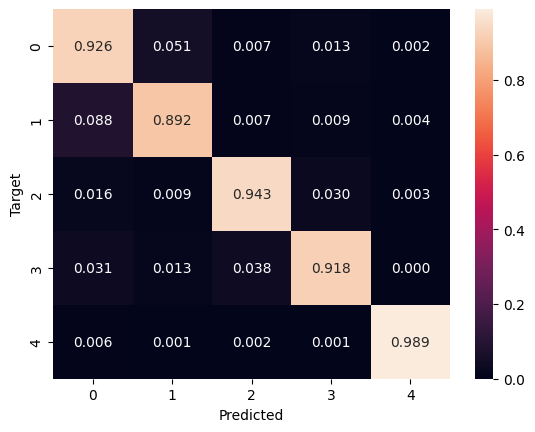

In [71]:
y, yhat = test_model(model, teststreamer)

plot_confusion_matrix(cfm)

# TRAINING WITH SMOTE DATASET

In [ ]:
trainfile = datadir / (config['arrhythmia'] + '_SMOTE_train.parq')
testfile = datadir / (config['arrhythmia'] + '_test.parq')
trainfile, testfile

In [74]:
from src import models
config = {
    "hidden": 128,
    "dropout": 0.2,
    "num_classes": 5,
    "num_heads": 8,
    "num_blocks": 1,
    "num_classes": 5,
    "shape": (16, 12)
}
print(config)
model = Transformer2DResNetWithAttention(config)
model
yhat = model(x)

{'hidden': 128, 'dropout': 0.2, 'num_classes': 5, 'num_heads': 8, 'num_blocks': 1, 'shape': (16, 12)}


In [75]:
model

Transformer2DResNetWithAttention(
  (conv2d): Conv2d(1, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (resnet_block): ResNetBlock2D(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (projection): Identity()
  )
  (se_block): SqueezeExciteBlock(
    (fc1): Linear(in_features=128, out_features=8, bias=True)
    (relu): ReLU()
    (fc2): Linear(in_features=8, out_features=128, bias=True)
    (sigmoid): Sigmoid()
  )
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (transformer_blocks): ModuleList(
    (0): TransformerBlock(
      (attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features

In [99]:
from mltrainer import Trainer, TrainerSettings, ReportTypes
import mlflow
import torch


def train_model(trainstreamer, teststreamer, config, settings=None):

        loss_fn = torch.nn.CrossEntropyLoss()

        with mlflow.start_run():
            optimizer = torch.optim.Adam

            if settings==None:
                # default settings
                settings = TrainerSettings(
                    epochs=15,
                    metrics=[accuracy, f1micro, f1macro, precision, recall],
                    logdir="logs/heart2D",
                    train_steps=len(trainstreamer) // 5,
                    valid_steps=len(teststreamer) // 5,
                    reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
                    scheduler_kwargs={"factor": 0.5, "patience": 2},
                    earlystop_kwargs={"patience": 8},
                )



            trainer = Trainer(
                model=model,
                settings=settings,
                loss_fn=loss_fn,
                optimizer=optimizer,
                traindataloader=trainstreamer.stream(),
                validdataloader=teststreamer.stream(),
                scheduler= config["scheduler"],
            )

            mlflow.set_tag("model", config["model"])
            mlflow.set_tag("dataset", "heart_big_SMOTE")
            mlflow.log_param("scheduler", str(trainer.scheduler).split(".")[-1])
            mlflow.log_param("earlystop", str(settings.earlystop_kwargs))

            base_config = {
                "hidden": config["hidden"],
                "dropout": config["dropout"],
                "num_classes": config["num_classes"],
                "num_heads": config["num_heads"],
                "num_blocks": config["num_blocks"],
                "shape": config["shape"]
            }
            mlflow.log_params(base_config)
            mlflow.log_param("epochs", settings.epochs)
            mlflow.log_param("shape0", config["shape"])
            mlflow.log_param("optimizer", str(optimizer))
            mlflow.log_params(settings.optimizer_kwargs)
            trainer.loop()



In [76]:
from mltrainer import Trainer, TrainerSettings, ReportTypes
import mlflow
import torch

loss_fn = torch.nn.CrossEntropyLoss()

with mlflow.start_run():
    optimizer = torch.optim.Adam

    settings = TrainerSettings(
        epochs=15,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="logs/heart2D",
        train_steps=len(trainstreamer) // 5, #met 5 epochs heeft het een keer de hele dataset gezien
        valid_steps=len(teststreamer) // 5,
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs={"factor": 0.5, "patience": 2},
        earlystop_kwargs= {"patience": 8},
    )

    # modify the tags when you change them!
    mlflow.set_tag("model", "Transfomer2D_ResNetSE_MultiHeadAttention")
    mlflow.set_tag("dataset", "heart_big_binary")
    mlflow.log_param("scheduler", "ReduceLROnPlateau")
    mlflow.log_param("earlystop", "patiece: 8")

    mlflow.log_params(config)
    mlflow.log_param("epochs", settings.epochs)
    mlflow.log_param("shape0", config["shape"])
    mlflow.log_param("optimizer", str(optimizer))
    mlflow.log_params(settings.optimizer_kwargs)

    trainer = Trainer(
        #device=device,
        model=model,
        settings=settings,
        loss_fn=loss_fn,
        optimizer=optimizer,
        traindataloader=trainstreamer.stream(),
        validdataloader=teststreamer.stream(),
        scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau,
       # scheduler=None
        )
    trainer.loop()
    

2025-01-26 14:27:21.157 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to logs/heart2D/20250126-142721
2025-01-26 14:27:21.157 | INFO     | mltrainer.trainer:__init__:72 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.
100%|██████████| 1718/1718 [00:43<00:00, 39.91it/s]
2025-01-26 14:28:05.847 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.4961 test 0.4645 metric ['0.8470', '0.8470', '0.6315', '0.8470', '0.8865']
100%|██████████| 1718/1718 [00:42<00:00, 40.36it/s]
2025-01-26 14:28:50.059 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.2846 test 0.2220 metric ['0.9226', '0.9226', '0.7194', '0.9226', '0.8998']
100%|██████████| 1718/1718 [00:42<00:00, 40.27it/s]
2025-01-26 14:29:34.381 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.2354 test 0.3345 metric ['0.8745', '0.8745', '0.6706', '0.8745', '0.9085']
2025-01-26 14:29:34.381 | INFO     | mltrainer.trainer:__call__:234 - best loss: 0.2220, current loss

{'hidden': 128, 'dropout': 0.2, 'num_classes': 5, 'num_heads': 8, 'num_blocks': 1, 'shape': (16, 12)}


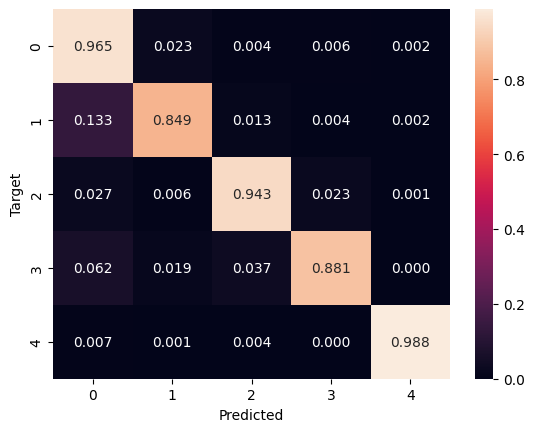

In [79]:
y, yhat = test_model(model, teststreamer)
cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)
print(config)
plot_confusion_matrix(cfm)

In [100]:
settings = TrainerSettings(
        epochs=15,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="logs/heart2D",
        train_steps=len(trainstreamer) // 5, #met 5 epochs heeft het een keer de hele dataset gezien
        valid_steps=len(teststreamer) // 5,
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs={"factor": 0.5, "patience": 2},
        earlystop_kwargs= {"patience": 8},
    )


In [101]:
from src import models
config = {
    "model": "Transformer2DResNetSE",
    "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau,
    "hidden": 128,
    "dropout": 0.2,
    "num_classes": 5,
    "num_heads": 8,
    "num_blocks": 1,
    "num_classes": 5,
    "shape": (16, 12),
   
}
print(config)
model = Transformer2DResNetSE(config)
model
yhat = model(x)

{'model': 'Transformer2DResNetSE', 'scheduler': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'hidden': 128, 'dropout': 0.2, 'num_classes': 5, 'num_heads': 8, 'num_blocks': 1, 'shape': (16, 12)}


In [102]:
train_model(trainstreamer, teststreamer, config, settings)

2025-01-26 15:12:12.718 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to logs/heart2D/20250126-151212
2025-01-26 15:12:12.719 | INFO     | mltrainer.trainer:__init__:72 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.
100%|██████████| 1718/1718 [00:42<00:00, 40.60it/s]
2025-01-26 15:12:56.685 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.5008 test 0.4656 metric ['0.8837', '0.8837', '0.6603', '0.8837', '0.9005']
100%|██████████| 1718/1718 [00:42<00:00, 40.64it/s]
2025-01-26 15:13:40.591 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.3006 test 0.3365 metric ['0.8897', '0.8897', '0.6861', '0.8897', '0.8972']
100%|██████████| 1718/1718 [00:42<00:00, 40.66it/s]
2025-01-26 15:14:24.519 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.2504 test 0.2304 metric ['0.9198', '0.9198', '0.7214', '0.9198', '0.8964']
100%|██████████| 1718/1718 [00:42<00:00, 40.59it/s]
2025-01-26 15:15:08.476 | INFO     | mltrainer.tr

{'model': 'Transformer2DResNetSE', 'scheduler': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'hidden': 128, 'dropout': 0.2, 'num_classes': 5, 'num_heads': 8, 'num_blocks': 1, 'shape': (16, 12)}


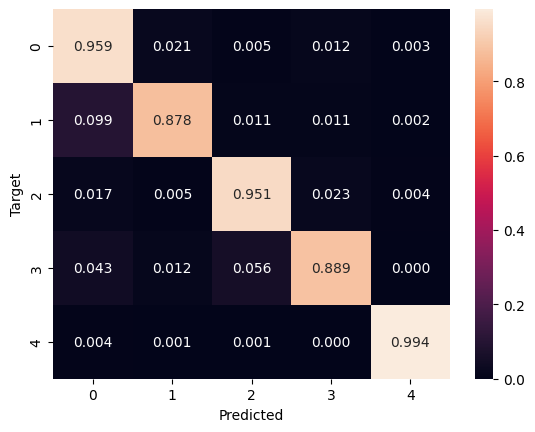

In [103]:
y, yhat = test_model(model, teststreamer)
cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)
print(config)
plot_confusion_matrix(cfm)